# **Hierarchy Design for MMoCHi**

**Authors:** Daniel Caron and William Specht

**MMoCHi classification is centered around user-defined hierarchies. In this tutorial we will walk through how to set up a hierarchy and will give tips and recommendations for designing your own hierarchies.**

## **Import packages**

In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['legend.frameon'] = 'False'
import mmochi as mmc
mmc.log_to_file('data/Hierarchy')

## **Downloading and preprocessing the data**
We will begin by downloading the data and performing preprocessing and landmark registration (see [Integrated Classification tutorial](./Integrated_Classification.ipynb)):

In [2]:
batches = ['pbmc_10k_protein_v3','5k_pbmc_protein_v3']
files = ['data/pbmc_10k_protein_v3.h5','data/5k_pbmc_protein_v3.h5']
urls = ['http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5',
        'http://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5']
adatas = mmc.utils.preprocess_adatas(files,
                                     backup_urls = urls, log_CP_ADT=1e3, log_CP_GEX=1e4)
adata = anndata.concat(adatas,merge='first',keys=batches, label='batch',index_unique='_')
adata.obsm['protein'].drop(['IgG2a_control','IgG2b_control','IgG1_control'],axis=1,inplace=True)
adata = mmc.landmark_register_adts(adata,batch_key='batch',single_peaks=['CD25'])

 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning:Some cells have zero counts
Running with batch batch


  0%|          | 0/2 [00:00<?, ?it/s]

## **Exploring the data**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As described in the [Integrated Classification tutorial](./Integrated_Classification.ipynb), before cell type classification, we recommend performing a cursory unsupervised analysis of your dataset. This will help inform which cell types to include in your hierarchy and can be used to evaluate the quality of various cell type markers. As before, because clustering is stochastic, the X_UMAP and leiden clusters have been provided as .csv files to load in for this tutorial.

In [3]:
if False:
    sc.pp.highly_variable_genes(adata)
    sc.pp.pca(adata)
    sc.external.pp.harmony_integrate(adata,adjusted_basis='X_pca',key='batch',
                                     verbose=False,max_iter_harmony=20)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    np.savetxt('data/Integrated_Classification_X_umap.txt',adata.obsm['X_umap'])
    adata.obs['leiden'].to_csv('data/Integrated_Classification_leiden.csv')
else:
    adata.obsm['X_umap'] = np.loadtxt('data/Integrated_Classification_X_umap.txt')
    adata.obs['leiden'] = pd.read_csv('data/Integrated_Classification_leiden.csv').set_index('Unnamed: 0')['leiden'].astype(str).astype('category')
    
protein_adata = anndata.AnnData(adata.obsm['landmark_protein'],adata.obs.copy(),dtype=float)
protein_adata.obsm['X_umap'] = adata.obsm['X_umap'].copy()

... storing 'feature_types' as categorical
... storing 'genome' as categorical


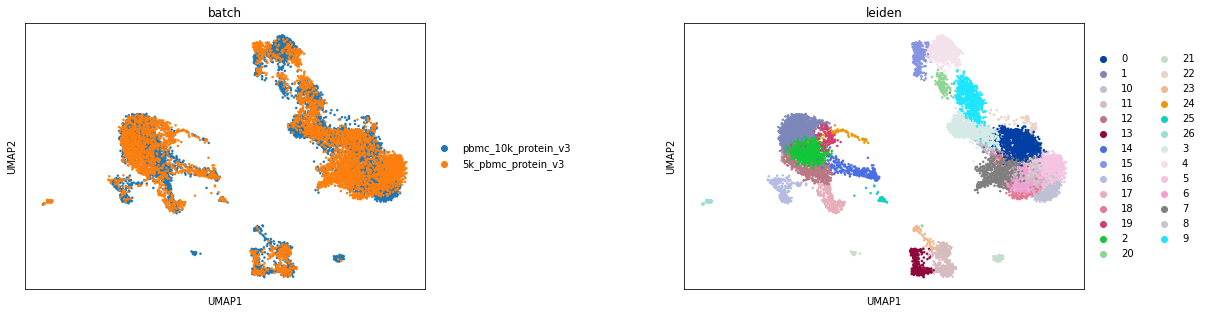

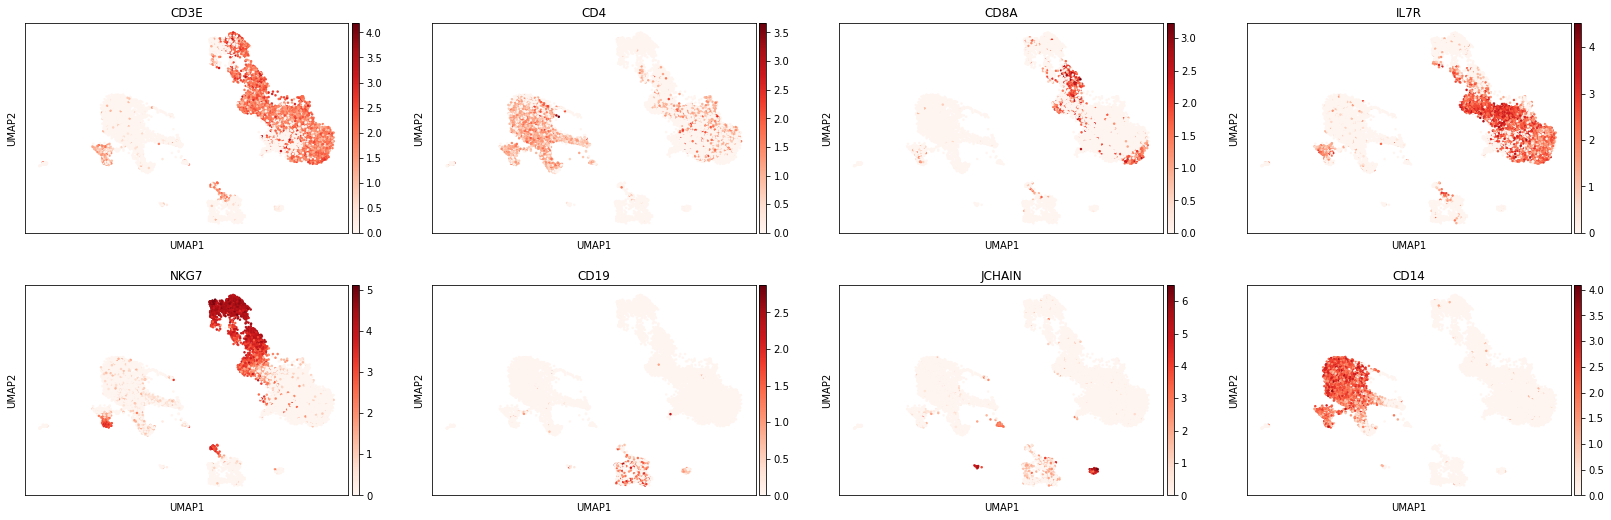

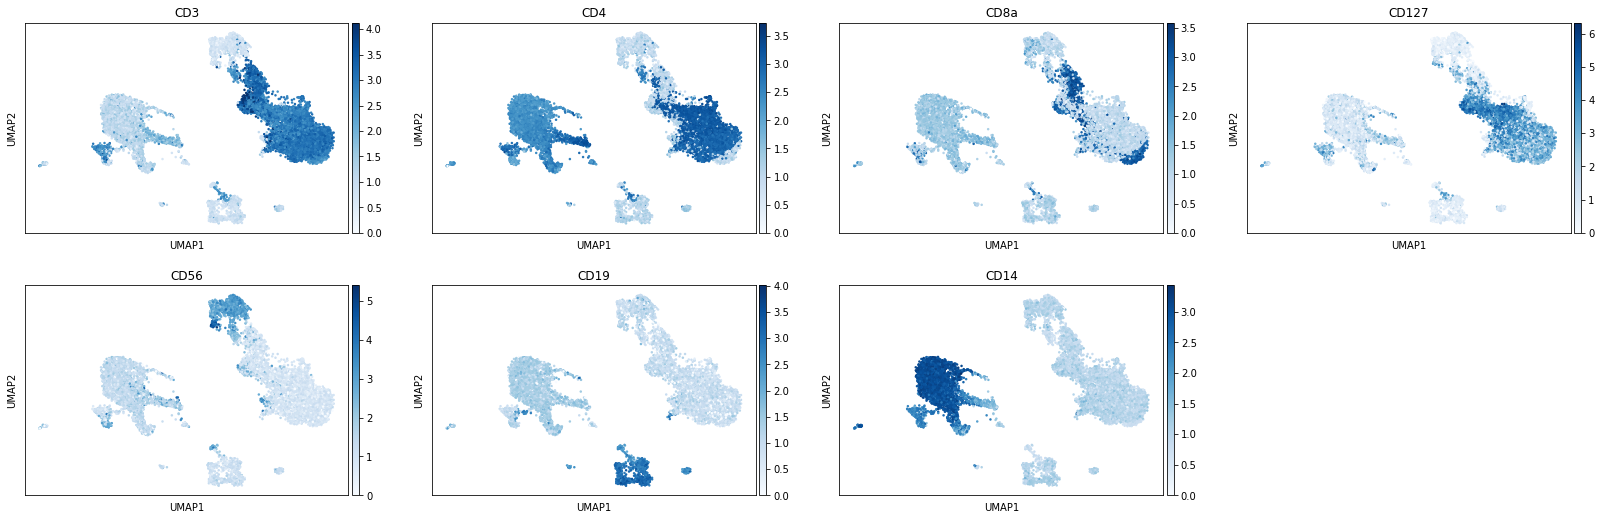

In [4]:
sc.pl.umap(adata,color=['batch','leiden'],s=25,sort_order=False,wspace =.5)
sc.pl.umap(adata,color=['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14'],
           s=25,sort_order=False, cmap='Reds')
sc.pl.umap(protein_adata,color=['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'],
           s=25,sort_order=False, cmap='Blues')

#### The first step in hierarchy design is defining your scope: What subsets would you like to annotate by classification? 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MMoCHi classification and unsupervised clustering each have their own strengths and weaknesses. In our experience, integrated classification requires extra care to annotate subsets that are unique to individual batches, while unsupervised clustering can separate these events with ease. Moreover, we recommend a minimum of at least 100 events be captured by high confidence thresholding for training with MMoCHi (although we have had some success with fewer training events). Thus, it may be easier to focus on classifying cell types that are represented across multiple samples. For cell types that are better annotated by other methods, MMoCHi hierarchies support cutoff layers (using `mmc.add_classification(is_cutoff=True)`), which simply subsets cells by cell metadata or high confidence thresholding without training a random forest.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here, we could design a hierarchy encompassing various blood immune cell subsets, including Monocytes, CD4<sup>+</sup> and CD8<sup>+</sup> T cells, B cells, plasma cells, NK cells, and ILCs. Next, we look though our clusters to identify if any do not belong to one of these groups. Leiden cluster 23 appears to be T/B cell doublets specific to one batch. Although these could have been removed during QC, if you want to keep these subsets in the `anndata.AnnData object` for later analysis, we can label them in the `.obs` for annotation by a cutoff layer. 

In [5]:
adata.obs['T_B doublets'] = adata.obs.leiden.isin(['23']).astype(str)

## **Choosing markers for your subsets**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;There are many resources detailing markers for cell types across many sample types. A few to start with include [the Human Protein Atlas](https://www.proteinatlas.org), [PanglaoDB](https://panglaodb.se/), [CellMarker](http://bio-bigdata.hrbmu.edu.cn/CellMarker/index.html), and [CellTypist encyclopedias](https://www.celltypist.org/encyclopedia/Immune/v2). These resources primarily focus on transcriptomic markers, but manufacturers have also compiled [resources for surface protein markers](https://www.rndsystems.com/resources/cell-markers). These databases can help you identify less familiar subsets and guide marker selection. There are also many guides for identifying cell type marker genes from within your dataset using differential expression, including [here](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) and [here](https://www.sc-best-practices.org). These can help you tune marker selection to your data and classify previously undescribed cell types. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Once you have a sense for what markers could be used to identify your cell types of interest, evaluate their expression in the data. Your main focus should be whether the marker is as *specific* for your cell type as you expect, and whether it is as *ubiquitous* as you expect. Due to vast differences in experimental design and sequencing technologies, markers useful in one study may not be as applicable to your dataset. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We have created a differential expression helper function to assist with the identification of marker genes. For example, here we will compare cytotoxic NK cells (NKG7<sup>+</sup> CD3<sup>-</sup>) to a subsets of cytotoxic T cells (NKG7<sup>+</sup> CD3<sup>-</sup>) enriched in cluster to identify and other markers distinguishing them. This plot uses `cmap='jet'` which better reveals where thresholds could be drawn.

... storing 'T_B doublets' as categorical
 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning:Trying to modify attribute `._uns` of view, initializing view as actual.


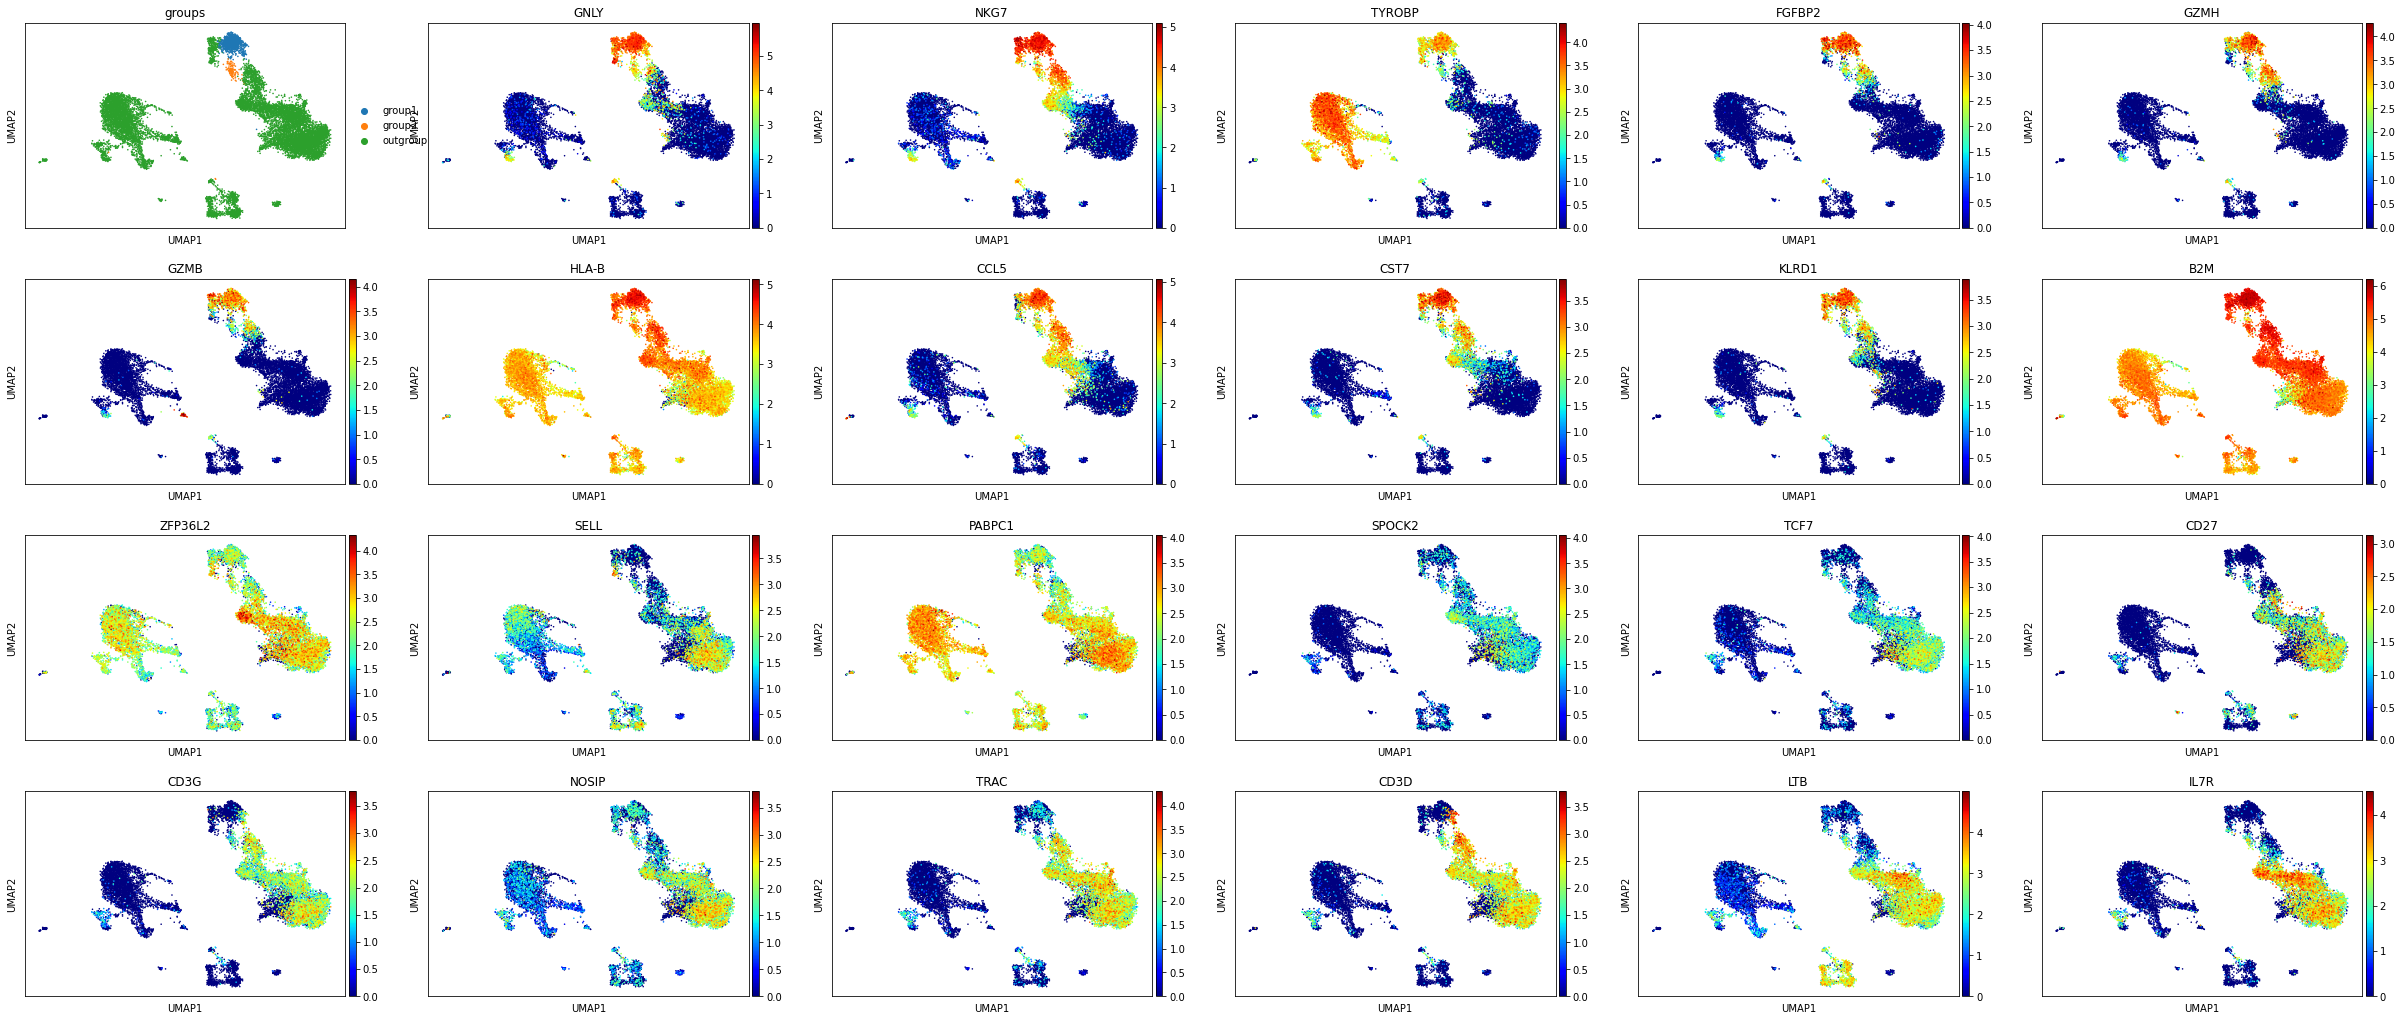

In [6]:
diff_expressed = mmc.identify_group_markers(adata, '4', '20', n_ups=11,n_downs=12)

Here we can see that *GNLY*, *TYROBP*, and *KRLD1* may be reliable transcriptomic markers of NK cells when properly thresholded. This also reveals that *CD3G* and *CD3D* may be more reliable T cell markers than *CD3E*, which is highly expressed within the NK clusters. We can also look at the results of the differential expression:

In [7]:
diff_expressed[diff_expressed.names.isin(['GNLY','TYROBP','KLRD1','CD3G','CD3D'])]

,names,scores,logfoldchanges,pvals,pvals_adj
0,GNLY,17.197853,1.553593,1.139582e-35,3.821929e-31
2,TYROBP,14.216040,2.010843,1.366719e-28,1.527901e-24
9,KLRD1,11.747744,1.563995,1.054777e-22,2.721162e-19
33532,CD3G,-9.948903,-2.873073,8.484899e-18,1.293484e-14
33535,CD3D,-11.975534,-2.809434,9.826088e-24,3.295473e-20


## **Building the Hierarchy**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will begin by creating a new `mmc.Hierarchy` object. In the initialization of the object, we can set a lot of default parameters, which will affect how classification layers perform. For example, here we set `default_min_events=15` so that MMoCHi will require at least 15 events to be used for training for each subset, and `default_class_weight='balanced'` to pass `class_weight='balanced'` to `sklearn.ensemble.RandomForestClassifier()`. Read more about various defaults that can be set in the docs. 

In [8]:
h = mmc.Hierarchy(default_min_events=15, default_class_weight='balanced')

#### Defining a cutoff node
To build out the hierarchy, we will progressively define classification and subset nodes. To organize the hierarchy each node is defined with a unique name for itself and the name of its parent node.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;First, we start with a classification node, which we will name `'Removal'` and use for separating cells we wish to classify from those we don't. This layer will be situated at the start of the hierarchy, directly beneath the root node (named `All` in the code). We also provide a list of features (generally gene or protein markers) for use during high confidence thresholding. To access the cell metadata stored in the `.obs` during high confidence thresholding, we simply provide the column name (e.g. `'T_B doublets'`). This layer is set to be a cutoff layer, which means that it will be used to directly subset cells, without training a random forest.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, we provide subset nodes, each with a name (e.g. `'Potential Doublets'`) and their parent (in this case, the `'Removal'` node). Each subset node is also defined with a list corresponding to their expression of the markers provided, or in this case, their expected values in the `.obs` column. This can also be provided as a list of lists (to specify multiple satisfactory conditions) or as a dictionary of keyword arguments to pass to `mmc.hc_defs` for generation of a list of lists. (more on that later).

In [9]:
h.add_classification('Removal', 'All', ['T_B doublets'], is_cutoff=True) 
h.add_subset('Potential Doublets','Removal', ['True'])
h.add_subset('To classify', 'Removal', ['False'])

Now let's run this single-layer classifier and see the result!

In [10]:
adata,h = mmc.classify(adata, h, 'lin','landmark_protein', batch_key='batch', retrain = True, weight_integration=True) 
adata = mmc.terminal_names(adata)

Setting up...
Using .X and landmark_protein


Removing 18757 features lacking expression in a minimum of 25 events...
Resorting to enforce sorted order of features by name


Set up complete.
Using 14795 features


Running with batch batch
Using weights of: [0.4001677852348993, 0.5998322147651006] for random forest n_estimators


Data subsetted on All in All
Running high confidence populations for Removal...


Running high confidence thresholds in 5k_pbmc_protein_v3
Running high confidence thresholds in pbmc_10k_protein_v3


Performing cutoff for Removal...
Merging data into adata.obsm['lin']
Predicted:
To classify           13035
Potential Doublets       77
Name: Removal_class, dtype: int64


Converting columns in adata.obsm["lin"] to savable dtypes...


Great, looks like it worked correctly:

In [11]:
pd.crosstab(adata.obs.classification, adata.obs['T_B doublets'])

T_B doublets,False,True
classification,,
Potential Doublets,0,77
To classify,13035,0


#### A brief aside: defining a simple classification level
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lineage-level classification nodes tend to require many different markers to capture heterogenous populations. Before we dive into the next classification node, let's start with a simpler example. Let's say you have a dataset of only T cells, and are interested in selecting CD4 and CD8 T cells, based on expression of CD4 and CD8 protein, and *CD4* and *CD8A* transcripts. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will create an example hierarchy and add a classification level called `'Example level'`, specifying those markers. For convenience, markers defined will be searched for using `mmc.utils.get_data` (see docs for details). For markers with unique names across the `.var_names`, `.obsm[data_key].columns`, and `.obs.columns`, we can just define them by that exact name, or use a unique pattern which occurs in that name. Markers with non-unique names, `mmc.utils.get_data` will select the item from the `.obsm[data_key].columns` before searching the `.var_names` or `.obs.columns`. To bypass this automatic prioritization, users can append `'_mod_data_key'`. `'_gex'`, or `'_obs'` to the marker name. Additionally, to allow for the specification of multiple thresholds for a single marker (e.g. to select an intermediate expression), users can append `'_hi'` or `'_lo'` to the marker's name. Here, you can see that we select both `'CD4'` to select the protein and `'CD4_gex'` to specify the transcript. 

Next, we will define subsets for CD4 and CD8 T cells, both with `'Example level'` as their parent node. We can then specify expression levels using 'pos' (for positive), 'neg' (for negative) and 'any' (for no restriction on expression of this marker) in a list. Here we define CD4 T cells as \[CD4<sup>+</sup> CD8<sup>-</sup> *CD4*<sup>+</sup> *CD8A*<sup>-</sup>\] and CD8 T cells as \[CD4<sup>-</sup> CD8<sup>+</sup> *CD4*<sup>-</sup> *CD8A*<sup>+</sup>\]. We can quickly visualize this using the `.display()` method.


In [12]:
example_h = mmc.Hierarchy()
example_h.add_classification('Example level','All',['CD4','CD8','CD4_gex','CD8A_gex'])
example_h.add_subset('CD4 T cell','Example level',['pos','neg','pos','neg'])
example_h.add_subset('CD8 T cell','Example level',['neg','pos','neg','pos'])
example_h.display()

All
└── *Example level*
    ├── CD4 T cell (CD4+ CD8- CD4_gex+ CD8A_gex-)
    └── CD8 T cell (CD4- CD8+ CD4_gex- CD8A_gex+)



&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Specifying these subsets as positive for both the protein *and* transcript is quite restrictive, especially considering the low expression of *CD4* transcript. We may be interested in specifying that the high confidence cells express either the protein or transcript. We can do this by providing a list of `['pos','neg','any']` lists, each specifying a satisfactory condition for labeling events as high confidence. For example we could do the following:


In [13]:
example_h = mmc.Hierarchy()
example_h.add_classification('Example level','All',['CD4','CD8','CD4_gex','CD8A_gex'])
example_h.add_subset('CD4 T cell','Example level',[['any','neg','pos','neg'],['pos','neg','any','neg']])
example_h.add_subset('CD8 T cell','Example level',[['neg','any','neg','pos'],['neg','pos','neg','any']])
example_h.display()

All
└── *Example level*
    ├── CD4 T cell (CD8- CD8A_gex-) and [(CD4_gex+) or (CD4+)]
    └── CD8 T cell (CD4- CD4_gex-) and [(CD8A_gex+) or (CD8+)]



#### Defining a random forest classification node
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Great, now let's repeat the process to define another classification node and subsets. This one will be named `'Broad Lineages'`, will run on `'To classify'`, and will use a mix of gene and protein markers for high confidence thresholding. We then will supply subsets with names (`'Lymphocyte'` and `'Myelocyte'`), both underneath `'Broad Lineages'`. For these subsets, we would like to use fairly complex marker definitions (expression of any 1 or any 2 of a list of markers), which would be hard to express as a list of lists (see comments). Thus, we have created a helper function to generate these complex rules (`mmc.hc_defs`), which is our preferred method for inputting definitions for subsets. To use it, pass a dictionary of keyword arguments specifying marker expression, using the keyword `pos` for any positive markers, `neg` for any negative markers and `any_of` for complex rules:

In [14]:
h.add_classification('Broad Lineages','To classify', ['CD14','CD33','MARCO','MERTK','CD3','CD19','CD127','JCHAIN','LILRA4']) 
# h.add_subset('Lymphocyte','Broad Lineages', [['neg', 'neg', 'neg', 'neg', 'pos', 'pos', 'any', 'any'],
#                                             ['neg', 'neg', 'neg', 'neg', 'pos', 'any', 'pos', 'any'],
#                                             ['neg', 'neg', 'neg', 'neg', 'pos', 'any', 'any', 'pos'],
#                                             ['neg', 'neg', 'neg', 'neg', 'any', 'pos', 'pos', 'any'],
#                                             ['neg', 'neg', 'neg', 'neg', 'any', 'pos', 'any', 'pos'],
#                                             ['neg', 'neg', 'neg', 'neg', 'any', 'any', 'pos', 'pos']])
h.add_subset('Lymphocyte','Broad Lineages',dict(neg = ['CD14','CD33','MARCO','MERTK'],any_of=['CD3','CD19','CD127','JCHAIN'],n=2))

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In addition to selecting any 1 or any few markers, there is one other type of complex rule we may want to introduce, which is a list of multiple conditions to satisfy. This is supported by providing a list of marker sets to `any_of`, and a list of integers to `n`. There is an additional parameter for how to link these conditions together, with `'&'` (when all `any_of` conditions must be met) or `'|'` connectors (when only one of the `any_of` conditions must be met). Here we want to specify Myelocytes must express (either CD14 or CD33) or (both *MARCO* and *MERTK*) or (*LILRA4*). Then, let's observe the hierarchy to make sure our definitions are correct: 

In [15]:
h.add_subset('Myelocyte','Broad Lineages',dict(any_of = [['CD14','CD33'],['MARCO','MERTK'],['LILRA4']],n=[1,2,1], any_ofs_connector = '|', neg=['CD3','CD19','CD127','JCHAIN']))
h.display()

All
└── *Removal*
    ├── Potential Doublets (T_B doublets==True)
    └── To classify (T_B doublets==False)
        └── *Broad Lineages*
            ├── Lymphocyte (CD14- CD33- MARCO- MERTK-) and [2 of (CD3+ CD19+ CD127+ JCHAIN+)]
            └── Myelocyte (CD3- CD19- CD127- JCHAIN-) and [1 of (CD14+ CD33+) or 2 of (MARCO+ MERTK+) or 1 of (LILRA4+)]



You can refer to the `mmc.hc_defs` docs for more details:

In [16]:
help(mmc.hc_defs)

Help on function hc_defs in module mmochi.hierarchy:

hc_defs(marker_list: List[str], pos: Union[List[str], str] = [], neg: Union[List[str], str] = [], other: Union[List[str], str] = [], POS: str = 'pos', NEG: str = 'neg', OTHER: str = None, UNDEFINED: str = 'any', any_of: Union[List[str], List[List[str]]] = [], any_ofs_connector: str = '&', n: Union[List[int], int] = 1, ANY_OPTIONS: Union[List[List[str]], List[str]] = ['pos', 'any'])
    Helper function for defining simple or complex gating strategies for high confidence thresholding. 
    
    Parameters 
    ----------
    marker_list
        All the markers in the group, usually set by the classification/cutoff defintion above. Markers can also have "_lo" or "_hi" appeneded
        to them to specify multiple thresholds on the same marker at the same level.
    pos
    neg
    other
        Lists of markers that must be positive, negative, or other
    POS
    NEG
    OTHER
        Strings that contain the value to write for those 

<div class="alert alert-info">
    
**Tip — Subset definitions** 
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For all classifications, it is generally useful to define any subset with at least one positive and one negative feature. Defining a subtype only negatively can be especially problematic, as both gene and (to a lesser degree) protein expression suffer from dropout, meaning expression of these markers may not be captured on all events. 
</div>

#### Thresholding
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We recommend building your hierarchy out one level at a time, thresholding and testing each level before building another. This is especially important when selecting thresholds for rare populations, whose expression of a marker might be hard to see on histograms of the entire dataset. Here we will subset to events intended for classification (as defined above). For more details on selecting thresholds, see the [High Confidence Thresholding tutorial](./High_Confidence_Thresholding.ipynb).

In [17]:
h.reset_thresholds()
h.load_thresholds('data/integrated_thresholds.csv')

Loaded thresholds.


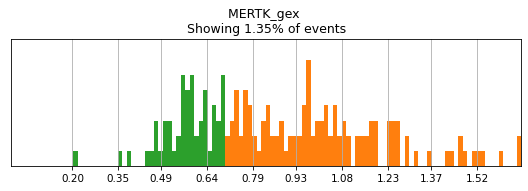

FloatSlider(value=0.7, layout=Layout(width='600px'), max=1.663966178894043)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=1.663966178894043)

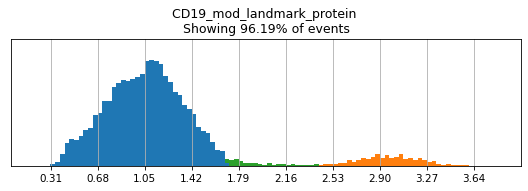

FloatSlider(value=2.4, layout=Layout(width='600px'), max=4.009825242409079)

FloatSlider(value=1.7000000000000002, layout=Layout(width='600px'), max=4.009825242409079)

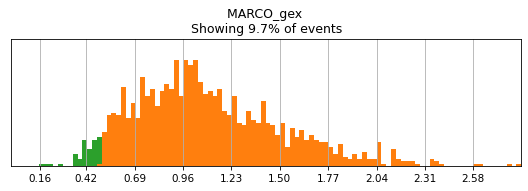

FloatSlider(value=0.5, layout=Layout(width='600px'), max=2.8468706607818604)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=2.8468706607818604)

T_B doublets not found in adata, skipping thresholding.


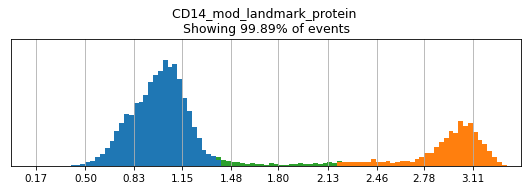

FloatSlider(value=2.2, layout=Layout(width='600px'), max=3.433803744204542)

FloatSlider(value=1.4, layout=Layout(width='600px'), max=3.433803744204542)

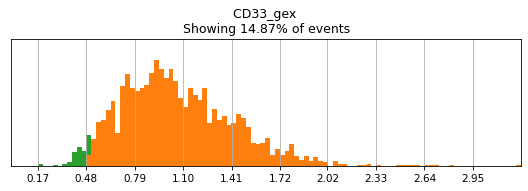

FloatSlider(value=0.5, layout=Layout(width='600px'), max=3.257295608520508)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=3.257295608520508)

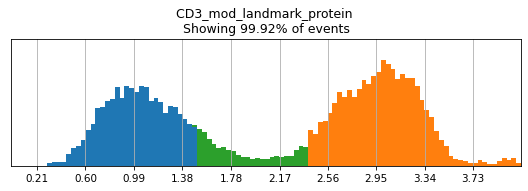

FloatSlider(value=2.4, layout=Layout(width='600px'), max=4.120174659562347)

FloatSlider(value=1.5, layout=Layout(width='600px'), max=4.120174659562347)

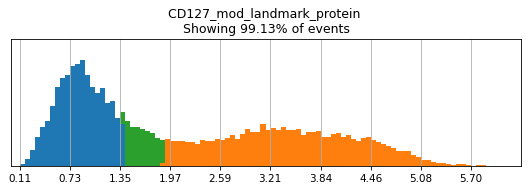

FloatSlider(value=1.9, layout=Layout(width='600px'), max=6.320133566083647)

FloatSlider(value=1.4, layout=Layout(width='600px'), max=6.320133566083647)

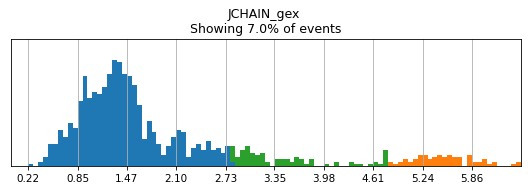

FloatSlider(value=4.8, layout=Layout(width='600px'), max=6.490779399871826)

FloatSlider(value=2.8, layout=Layout(width='600px'), max=6.490779399871826)

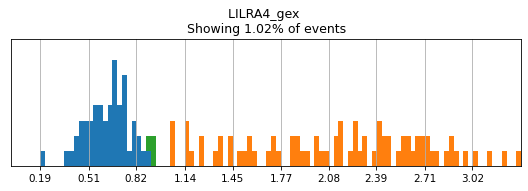

FloatSlider(value=1.0, layout=Layout(width='600px'), max=3.3392159938812256)

FloatSlider(value=0.9, layout=Layout(width='600px'), max=3.3392159938812256)

Completed!


Button(description='Click to run thresholds!', style=ButtonStyle())

Output()

In [18]:
h.run_all_thresholds(adata[adata.obs.classification=='To classify'],data_key='landmark_protein',mode='fancy rerun all')

#### Running classification
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Now, let's run classification at this level and evaluate the results! To prevent repetitively computing the classification, we have `skip_to` and `end_at` parameters that can be used to select which levels of the hierarchy should be rerun. This relies on information from previous runs being stored in the `.obsm['lin']`

In [19]:
adata,h = mmc.classify(adata, h, 'lin', 'landmark_protein', batch_key='batch', retrain=True, weight_integration=True, skip_to='Broad Lineages') 
adata = mmc.terminal_names(adata)

Setting up...
Using .X and landmark_protein


Removing 18757 features lacking expression in a minimum of 25 events...
Resorting to enforce sorted order of features by name


Set up complete.
Using 14795 features


Skipped to classification on Broad Lineages
Running with batch batch
Using weights of: [0.4001677852348993, 0.5998322147651006] for random forest n_estimators


Data subsetted on To classify in Removal
Running high confidence populations for Broad Lineages...


Running high confidence thresholds in 5k_pbmc_protein_v3
Running high confidence thresholds in pbmc_10k_protein_v3


Preparing training data for Broad Lineages...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True}
Manually made a balanced class_weight: {'Lymphocyte': 1.1704618231882273, 'Myelocyte': 1.9242771051127179}


Initializing classifier for Broad Lineages...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


2585 real cells in training set...


Resampling...


Found: 11 noise and 7 in danger of 2585 events.


Training with 3540 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.5s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


3172 real cells in training set...


Resampling...


Found: 59 noise and 0 in danger of 3172 events.


Training with 4756 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Running calibration on random forest


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished
Calibration will not include the 1/3rd mask
Calibrating with method isotonic
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Predicting for Broad Lineages...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


Merging data into adata.obsm['lin']
Predicted:
Lymphocyte    9210
Myelocyte     3825
Name: Broad Lineages_class, dtype: int64


[Parallel(n_jobs=16)]: Done 101 out of 101 | elapsed:    0.5s finished
Converting columns in adata.obsm["lin"] to savable dtypes...


We can then use UMAPs or other metrics to evaluate the classifications at this level before proceeding:

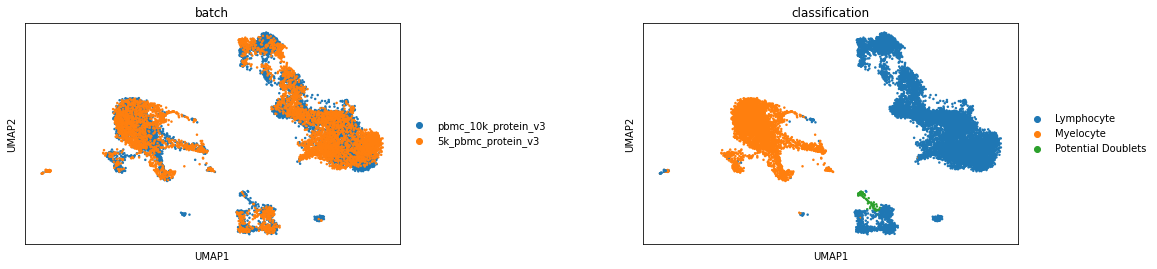

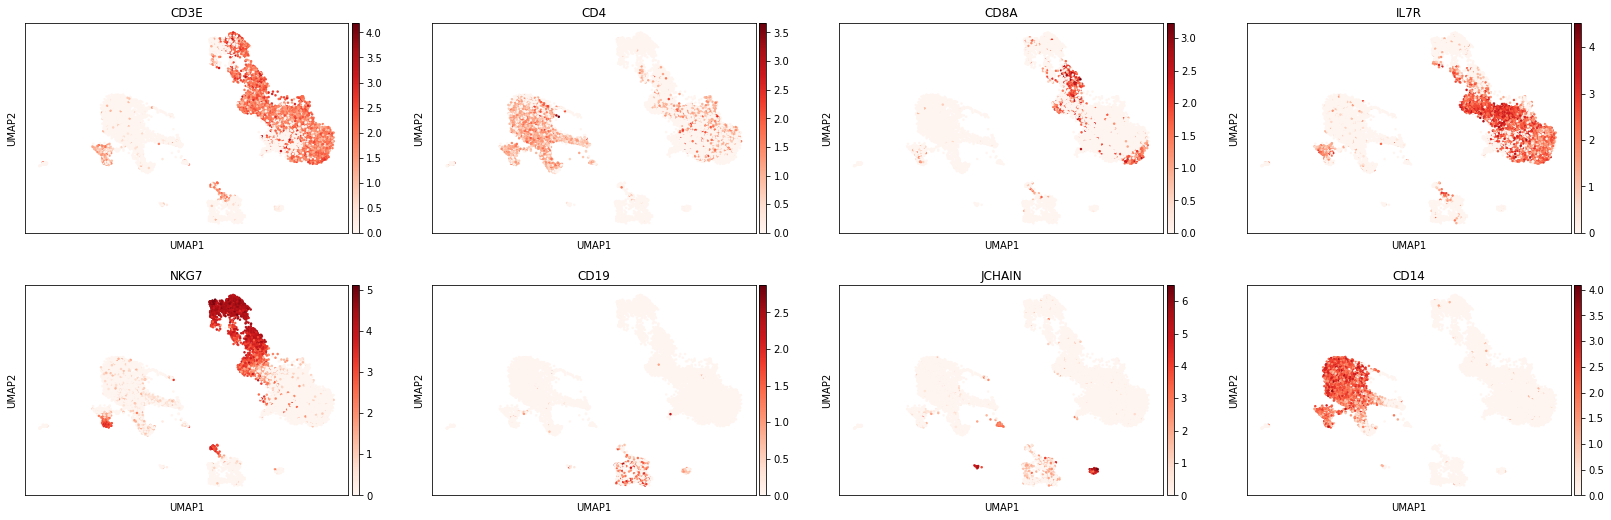

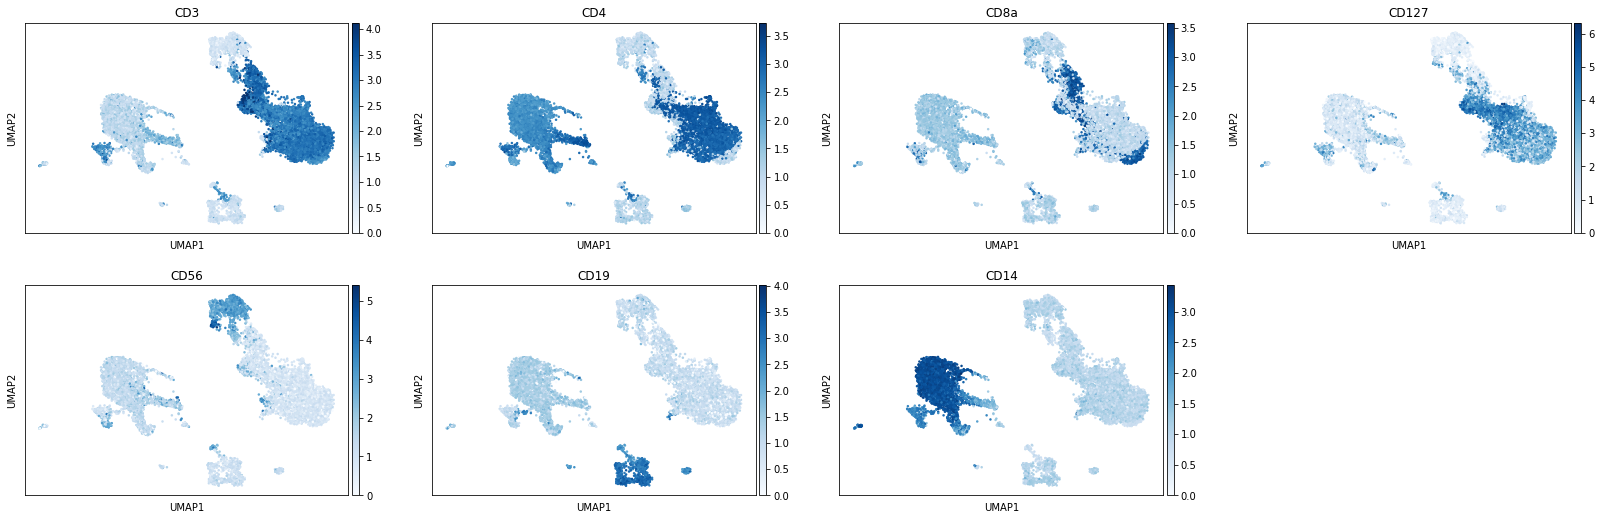

In [20]:
sc.pl.umap(adata,color=['batch','classification'],s=25,sort_order=False,wspace =.5)
sc.pl.umap(adata,color=['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14'],
           s=25,sort_order=False, cmap='Reds')
sc.pl.umap(protein_adata,color=['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'],
           s=25,sort_order=False, cmap='Blues')

#### Defining more classification levels
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Great, looks like that layer worked well. Now you can repeat this process for each additional classification layer until you have finished developing your hierarchy. We will discuss the remaining layers more broadly, rather than walking through each step of this process. We next defined classification levels for Lymphocyte subsets and CD4 and CD8 T cells. For lymphocyte subsets, we didn't need to implement anything unique. For CD4 and CD8 T cells, we have tested classification and tuned random forest hyperparameters (using `clf_kwargs`) to select more `max_features` at each level. Read more about kwarg options [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [21]:
h.add_classification('Lymphoid', 'Lymphocyte', ['CD3','CD19','CD56','CD127','JCHAIN'])
h.add_subset('T cell', 'Lymphoid', dict(pos=['CD3','CD127'],neg=['CD19','JCHAIN']))
h.add_subset('B cell', 'Lymphoid', dict(any_of=['CD19','CD3','CD127','JCHAIN']))
h.add_subset('Plasma cell','Lymphoid', dict(any_of=['JCHAIN'], neg=['CD3','CD127']))
h.add_subset('NK_ILC', 'Lymphoid', dict(neg=['CD19','JCHAIN','CD3'], any_of=['CD127','CD56']))

h.add_classification('CD4_CD8','T cell',['CD4','CD8','CD4_gex','CD8A_gex'],clf_kwargs=dict(max_features=.1))
h.add_subset('CD4 T cell','CD4_CD8',dict(neg=['CD8','CD8A_gex'],any_of=['CD4','CD4_gex']))
h.add_subset('CD8 T cell','CD4_CD8',dict(any_of=['CD8','CD8A_gex'],neg=['CD4','CD4_gex']))

<div class="alert alert-info">
    
**Tip — Hierarchy design** 
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here, the hierarchy is setup to reflect known shared precursors and cell lineages, but lineage-based hierarchies aren't always the most effective! When adding new cells to the hierarchy, consider what other cell types share the most transcriptomic and phenotypic identity. If two or more cell types share more features across an axis than they differ, it may be helpful to group them together and separate them lower in the hierarchy. 
</div>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Once created, you can use a helper function assign colors to each subset, and the hierarchy can be plotted using `plot=True` in the `.display()` method. 

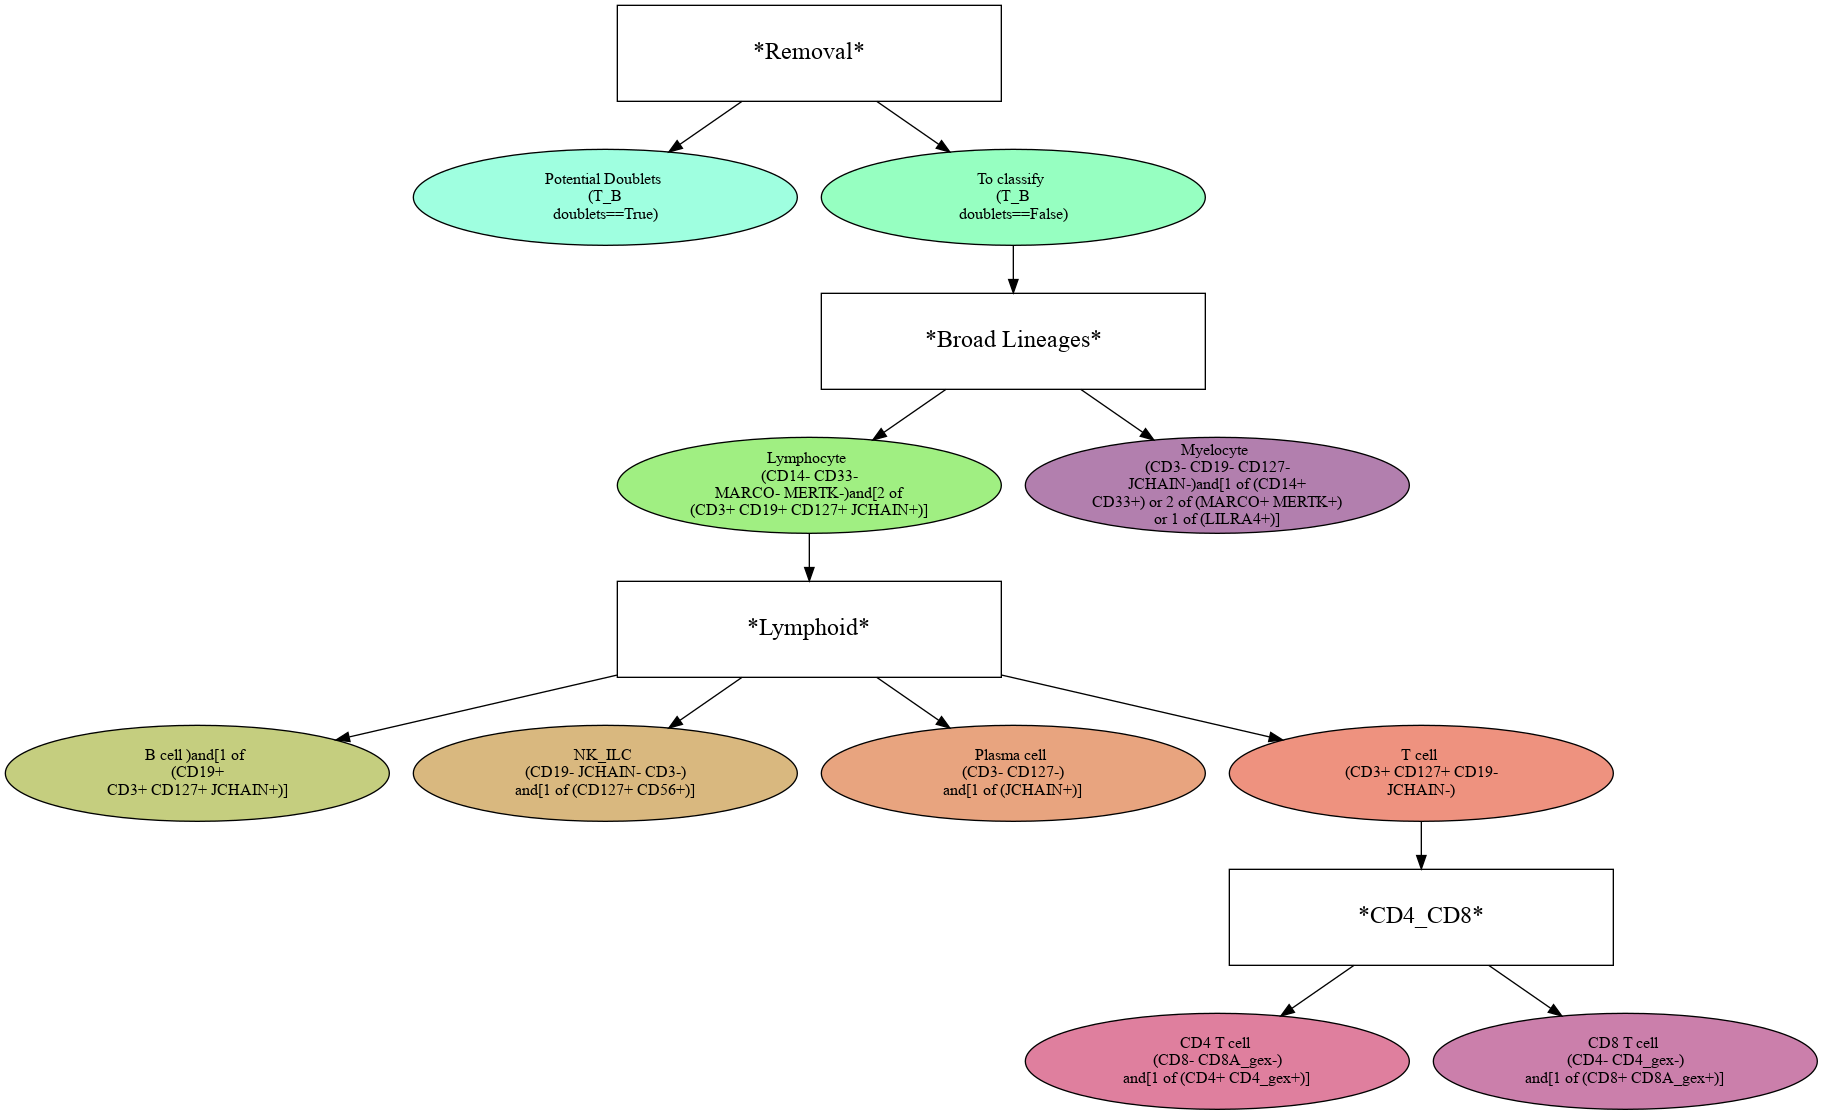

In [22]:
h.color_dict(True,rot=1,hue=3, mode='DEPTH')
h.display(plot=True,font_mult=.75)

<div class="alert alert-info">
    
**Tip — Subset colors** 

You can also define colors for subsets within each `h.add_subset` call. In that case, you can retrieve a dictionary of those colors for plotting purposes using `h.color_dict()`.
</div>

#### Flattening a hierarchy
Sometimes, classification performance is low due to poor hierarchy design. This could be for many reasons, such as accidentally grouping two very distinct subsets, or performing subsetting in a nonoptimal order. If you would like to test whether your hierarchical design at any given level makes sense, you can try flattening individual levels using the `h.flatten_children()` method. This method allows children to inheret the definitions of their parents to make flattening a hierarchy a bit easier. 

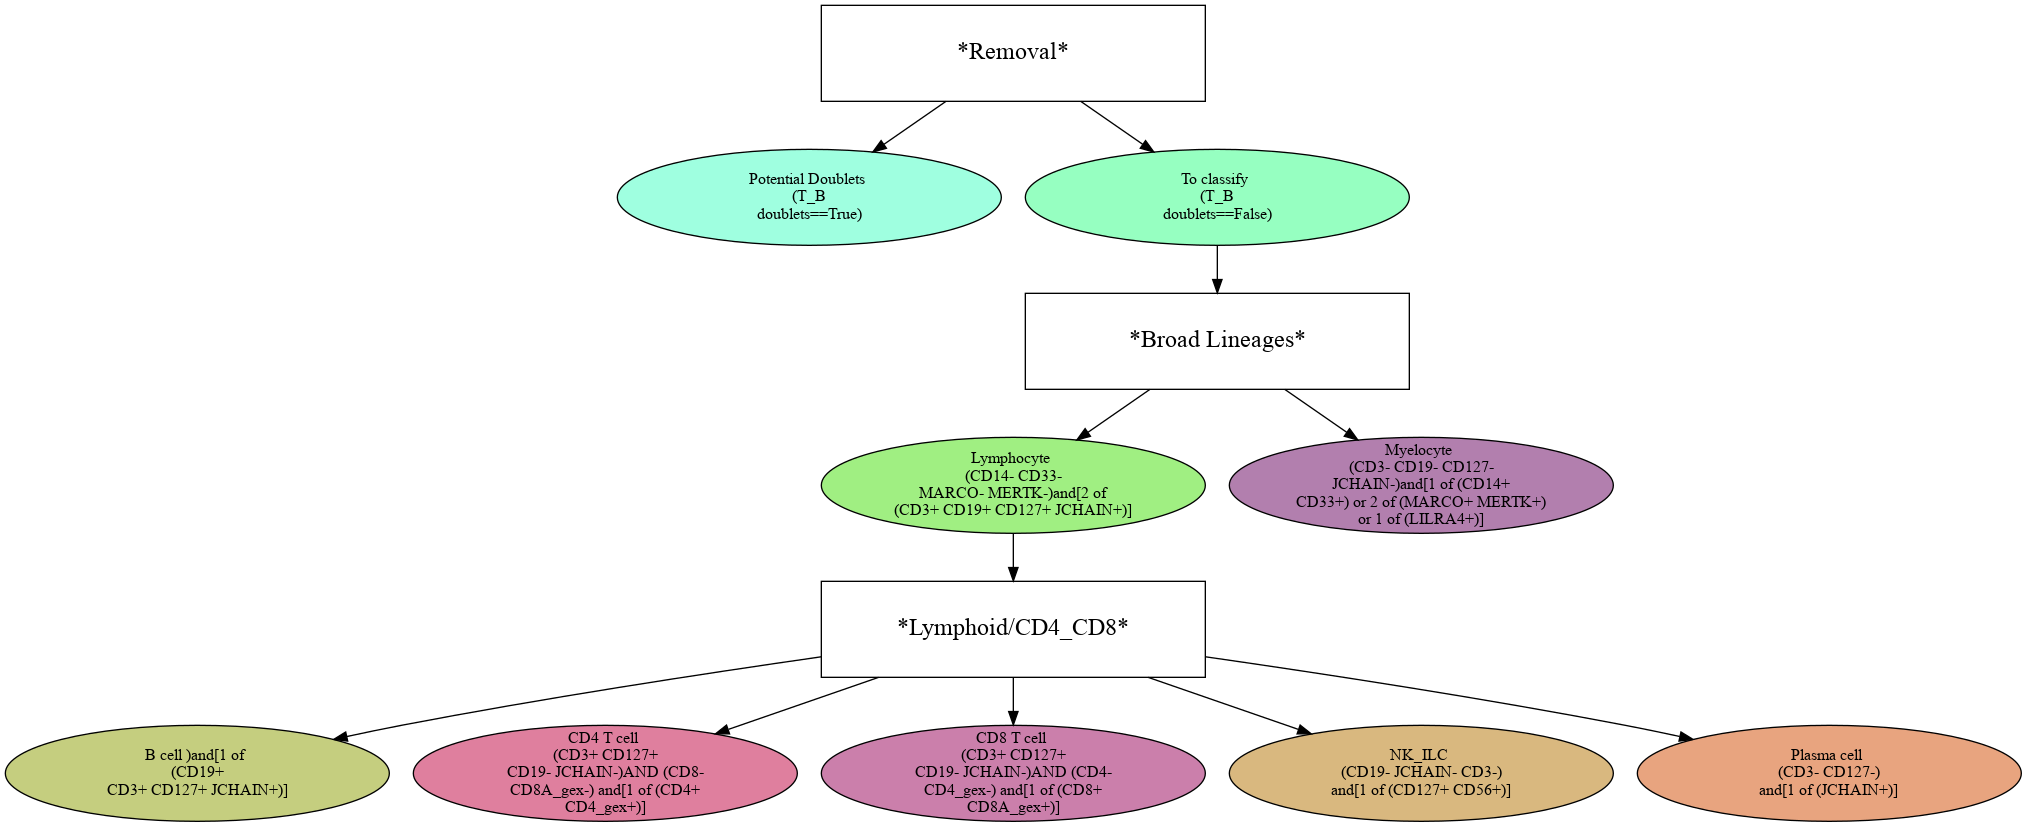

In [23]:
h.flatten_children('T cell')
h.display(True,font_mult=.75)

## **Saving and loading a hierarchy**
    
Once a hierarchy, it can be saved along with high confidence thresholding and any random forest classification performed for application to a new dataset.

In [24]:
h.save('data/ThresholdedHierarchy')

This hierarchy can then be loaded for application onto a new dataset

In [25]:
h = mmc.Hierarchy(load='data/IntegratedClassifier')

Loading classifier from data/IntegratedClassifier...


Loaded data/IntegratedClassifier.hierarchy


<div class="alert alert-success">
    
**Great!** 
    
Now you can create a hierarchy with complex expression dependencies!<br>
</div>